In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import joblib

In [ ]:
# Load dataset

In [3]:
df = pd.read_csv("apartment for rent dataset.csv", encoding='ISO-8859-1', sep=';')
print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")


Dataset loaded successfully!
Shape: (99492, 22)


C:\Users\pssha\AppData\Local\Temp\ipykernel_25116\4166090806.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("apartment for rent dataset.csv", encoding='ISO-8859-1', sep=';')


In [5]:
# Data Overview & Understanding

print("\n=== Data Overview ===")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())


=== Data Overview ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99492 entries, 0 to 99491
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             99492 non-null  int64  
 1   category       99492 non-null  object 
 2   title          99492 non-null  object 
 3   body           99492 non-null  object 
 4   amenities      83448 non-null  object 
 5   bathrooms      99429 non-null  float64
 6   bedrooms       99368 non-null  float64
 7   currency       99492 non-null  object 
 8   fee            99492 non-null  object 
 9   has_photo      99492 non-null  object 
 10  pets_allowed   39068 non-null  object 
 11  price          99491 non-null  float64
 12  price_display  99491 non-null  object 
 13  price_type     99492 non-null  object 
 14  square_feet    99492 non-null  int64  
 15  address        7943 non-null   object 
 16  cityname       99190 non-null  object 
 17  state          99190 non-nu

In [ ]:
# Data Cleaning

In [7]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
id                   0
category             0
title                0
body                 0
amenities        16044
bathrooms           63
bedrooms           124
currency             0
fee                  0
has_photo            0
pets_allowed     60424
price                1
price_display        1
price_type           0
square_feet          0
address          91549
cityname           302
state              302
latitude            25
longitude           25
source               0
time                 0
dtype: int64


In [9]:
# Handle missing values
df['amenities'] = df['amenities'].fillna('None')
df['square_feet'] = df['square_feet'].fillna(df['square_feet'].median())

In [13]:
# Convert price to numeric (remove $ and commas)
df['price'] = df['price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)


In [15]:
# Convert time to datetime
df['time'] = pd.to_datetime(df['time'], unit='s')

In [17]:
# Remove duplicates
df = df.drop_duplicates()
print(f"Shape after cleaning: {df.shape}")

Shape after cleaning: (99408, 22)


In [ ]:
# Feature Engineering

In [19]:
# Create price per square foot feature
df['price_per_sqft'] = df['price'] / df['square_feet']

In [21]:
# Create binary features for amenities
df['has_pool'] = df['amenities'].str.contains('Pool', case=False).astype(int)
df['has_gym'] = df['amenities'].str.contains('Gym', case=False).astype(int)
df['has_parking'] = df['amenities'].str.contains('Parking', case=False).astype(int)

In [ ]:
#EDA with Correlation and Outliers


=== Feature Correlation Heatmap ===


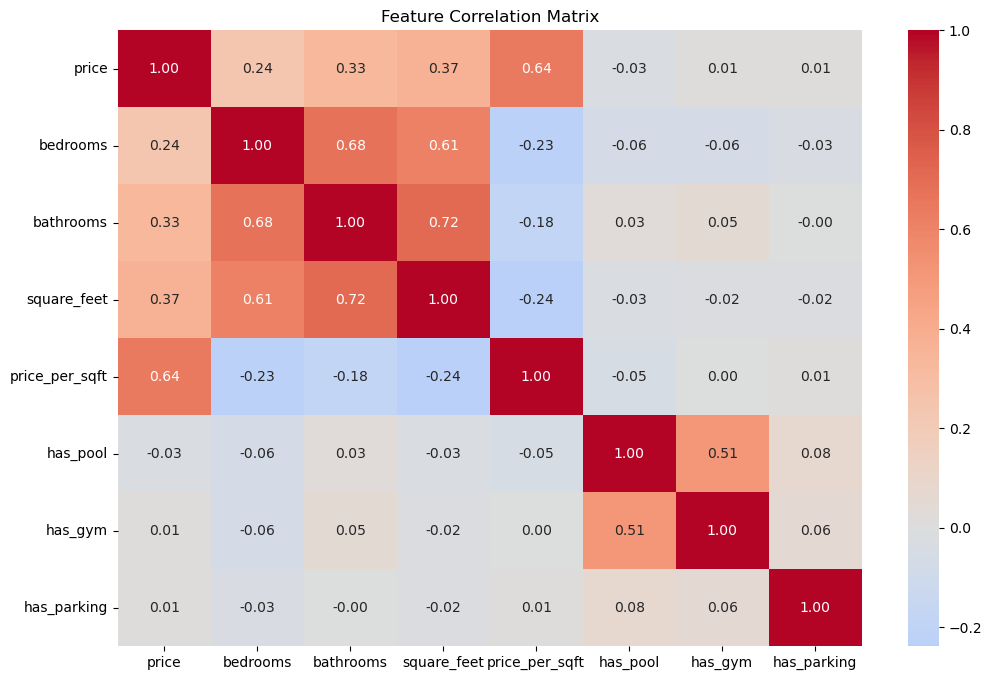

In [23]:
# Feature Correlation Heatmap
print("\n=== Feature Correlation Heatmap ===")
plt.figure(figsize=(12, 8))
corr_matrix = df[['price', 'bedrooms', 'bathrooms', 'square_feet', 
                 'price_per_sqft', 'has_pool', 'has_gym', 'has_parking']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()


In [25]:
# Outlier Detection
print("\n=== Outlier Analysis ===")
outlier_features = ['price', 'square_feet', 'price_per_sqft', 'bedrooms']



=== Outlier Analysis ===


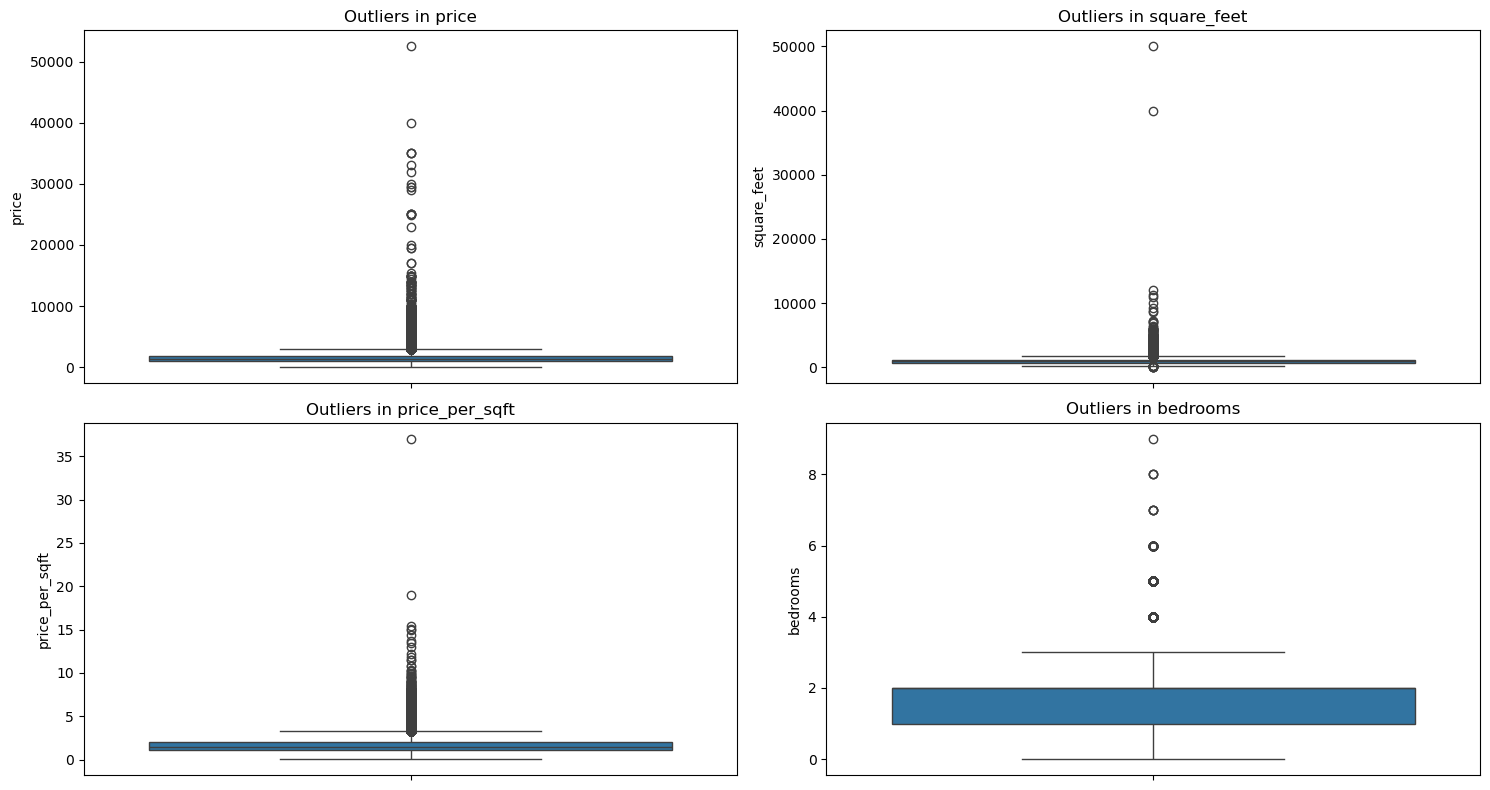

In [27]:
# Visual Outlier Detection

plt.figure(figsize=(15, 8))
for i, feature in enumerate(outlier_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df[feature])
    plt.title(f'Outliers in {feature}')
plt.tight_layout()
plt.show()

In [29]:
# Quantitative Outlier Analysis
print("\n=== Outlier Statistics ===")
for feature in outlier_features:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    print(f"\n{feature}:")
    print(f"- IQR: {iqr:.2f}")
    print(f"- Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"- Outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")



=== Outlier Statistics ===

price:
- IQR: 781.50
- Bounds: [-158.75, 2967.25]
- Outliers: 4695 (4.72%)

square_feet:
- IQR: 386.00
- Bounds: [150.00, 1694.00]
- Outliers: 2846 (2.86%)

price_per_sqft:
- IQR: 0.88
- Bounds: [-0.20, 3.32]
- Outliers: 4913 (4.94%)

bedrooms:
- IQR: 1.00
- Bounds: [-0.50, 3.50]
- Outliers: 1839 (1.85%)


In [31]:
# Outlier Treatment (Capping method)

print("\n=== Applying Outlier Capping ===")
for feature in outlier_features:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    df[feature] = np.where(df[feature] < lower_bound, lower_bound,
                         np.where(df[feature] > upper_bound, upper_bound, df[feature]))



=== Applying Outlier Capping ===



=== Post-Outlier Treatment Visualizations ===


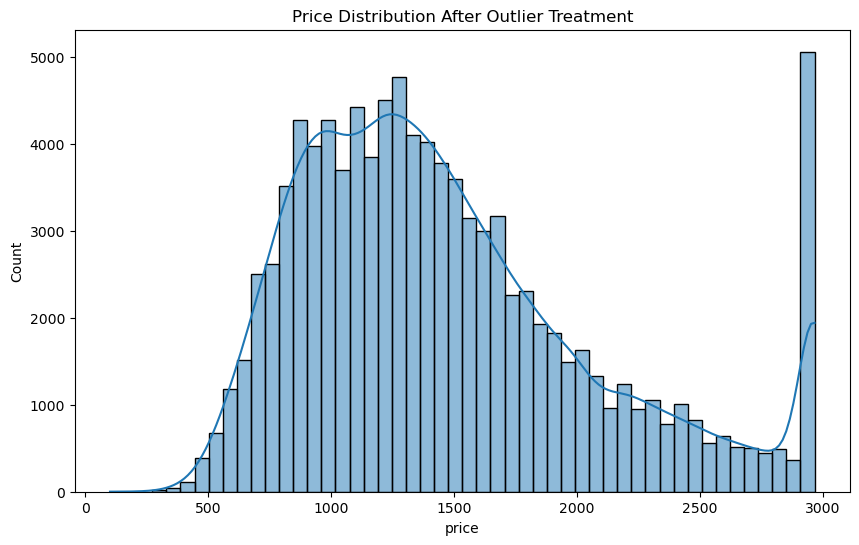

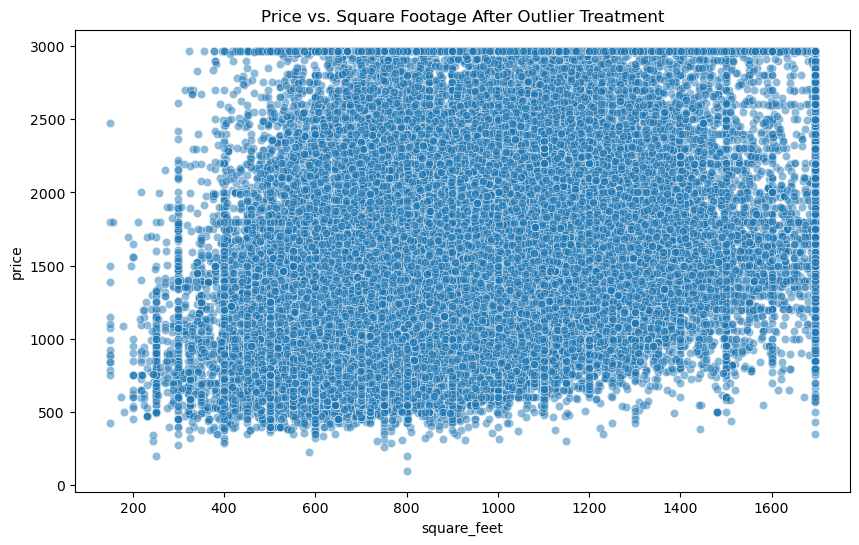

In [33]:
# Post-Treatment Visualization

print("\n=== Post-Outlier Treatment Visualizations ===")
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Price Distribution After Outlier Treatment')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='square_feet', y='price', alpha=0.5)
plt.title('Price vs. Square Footage After Outlier Treatment')
plt.show()

In [ ]:
# Clustering Analysis

In [37]:
 #Select features for clustering
cluster_features = df[['price', 'bedrooms', 'bathrooms', 'square_feet', 'price_per_sqft', 
                      'has_pool', 'has_gym', 'has_parking']]

In [39]:
# Handle any remaining missing values
cluster_features = cluster_features.fillna(cluster_features.median())

In [41]:
# Feature Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_features)

In [ ]:
# Determine optimal clusters 

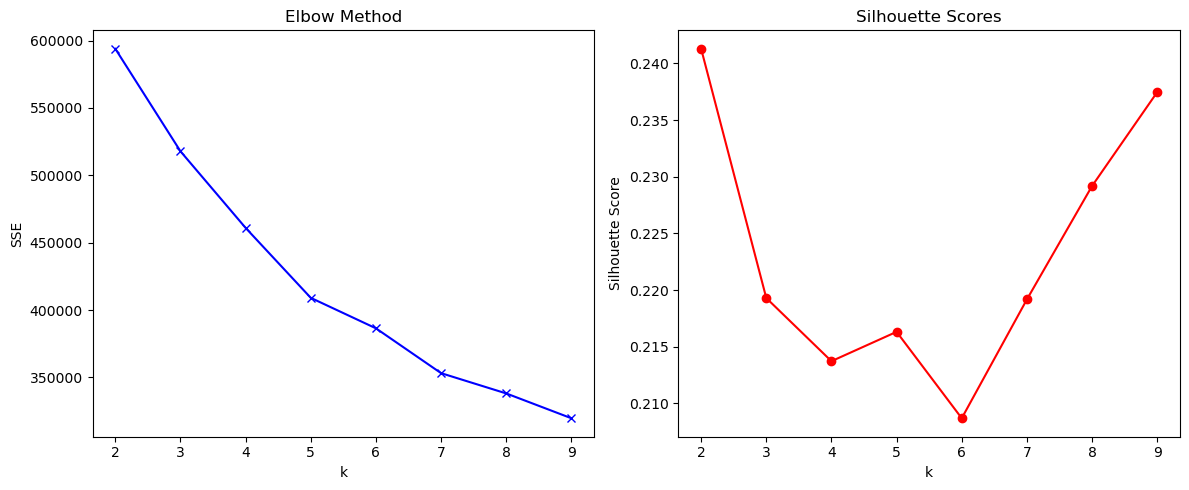

In [43]:
sse = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_scores.append(score)

# Plot elbow method and silhouette scores
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(K, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.tight_layout()
plt.show()

In [45]:
# Apply K-Means with optimal k

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

In [ ]:
# Cluster Profiling and Insights

          price  bedrooms  bathrooms  square_feet  price_per_sqft  has_pool  \
Cluster                                                                       
0        1579.0       2.0        2.0       1200.0            1.25      0.06   
1        1411.0       2.0        2.0       1100.0            1.27      0.89   
2        2099.0       1.0        1.0        754.0            2.82      0.36   
3        1037.0       1.0        1.0        750.0            1.42      0.42   

         has_gym  has_parking     cityname  Count  
Cluster                                            
0           0.04         0.40       Dallas  20988  
1           0.80         0.48    Las Vegas  21521  
2           0.36         0.43  Los Angeles  16758  
3           0.33         0.44       Dallas  40141  


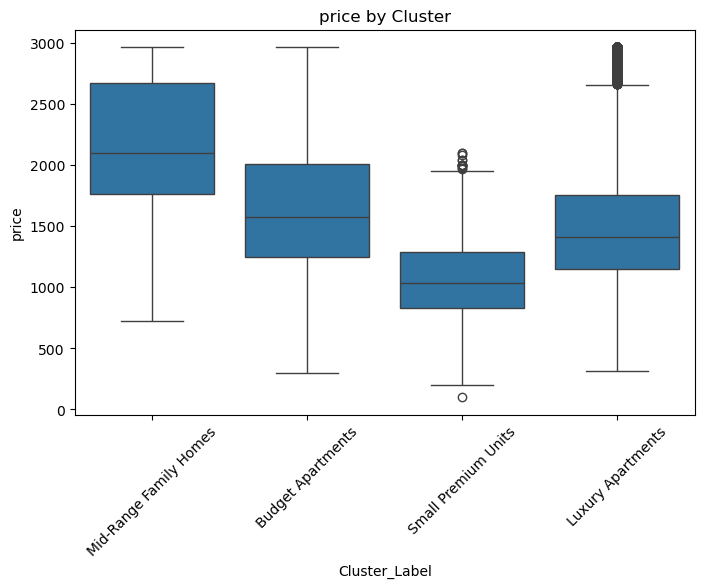

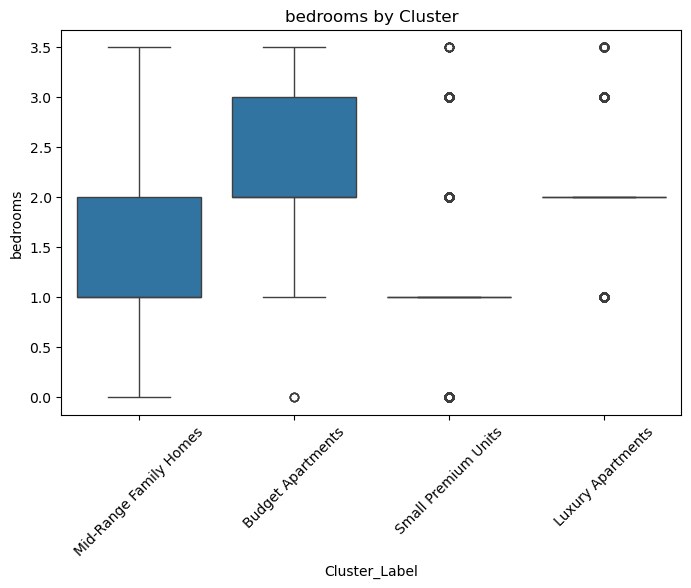

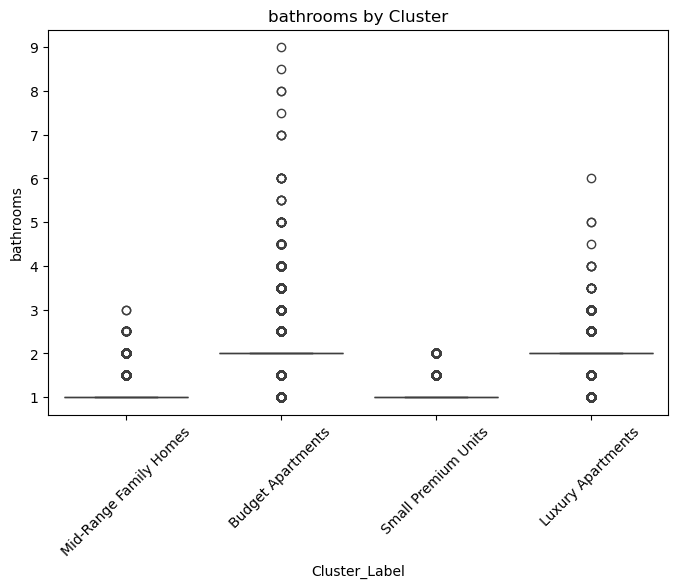

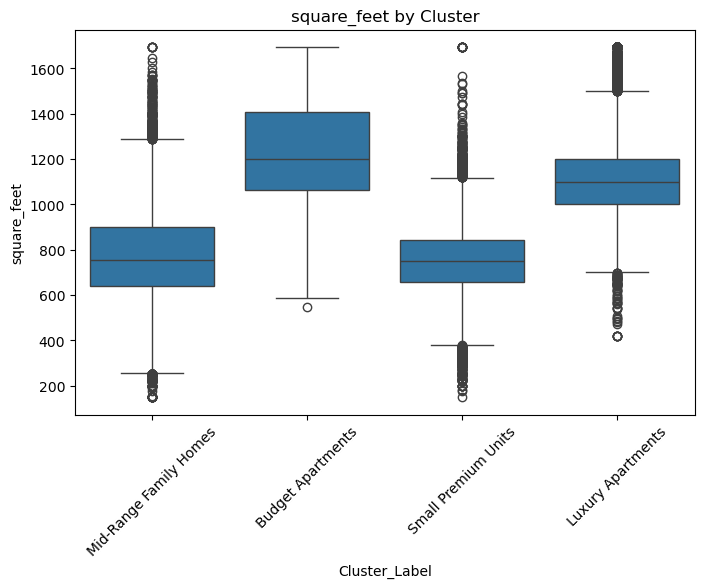

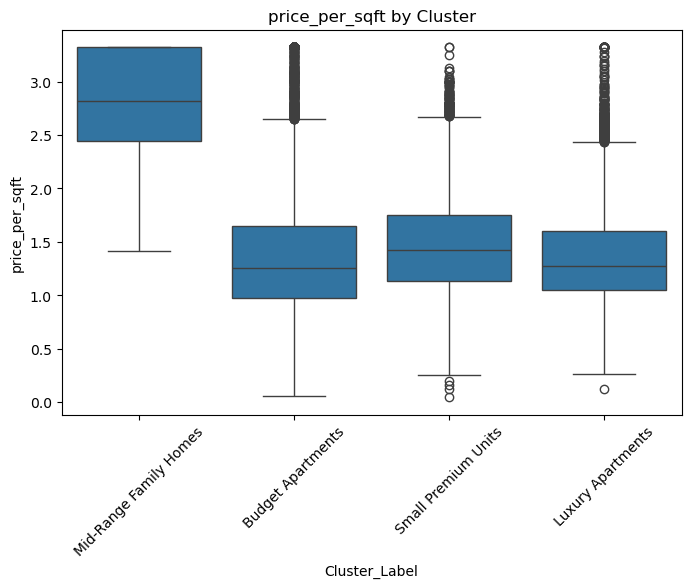

In [47]:
cluster_profile = df.groupby('Cluster').agg({
    'price': 'median',
    'bedrooms': 'median',
    'bathrooms': 'median',
    'square_feet': 'median',
    'price_per_sqft': 'median',
    'has_pool': 'mean',
    'has_gym': 'mean',
    'has_parking': 'mean',
    'cityname': lambda x: x.mode()[0]
}).round(2)

cluster_profile['Count'] = df['Cluster'].value_counts()
print(cluster_profile)

# Assign cluster labels
cluster_labels = {
    0: "Budget Apartments",
    1: "Luxury Apartments",
    2: "Mid-Range Family Homes",
    3: "Small Premium Units"
}
df['Cluster_Label'] = df['Cluster'].map(cluster_labels)

# Visualize clusters
for feature in ['price', 'bedrooms', 'bathrooms', 'square_feet', 'price_per_sqft']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='Cluster_Label', y=feature)
    plt.title(f'{feature} by Cluster')
    plt.xticks(rotation=45)
    plt.show()


In [ ]:
# PCA Visualization

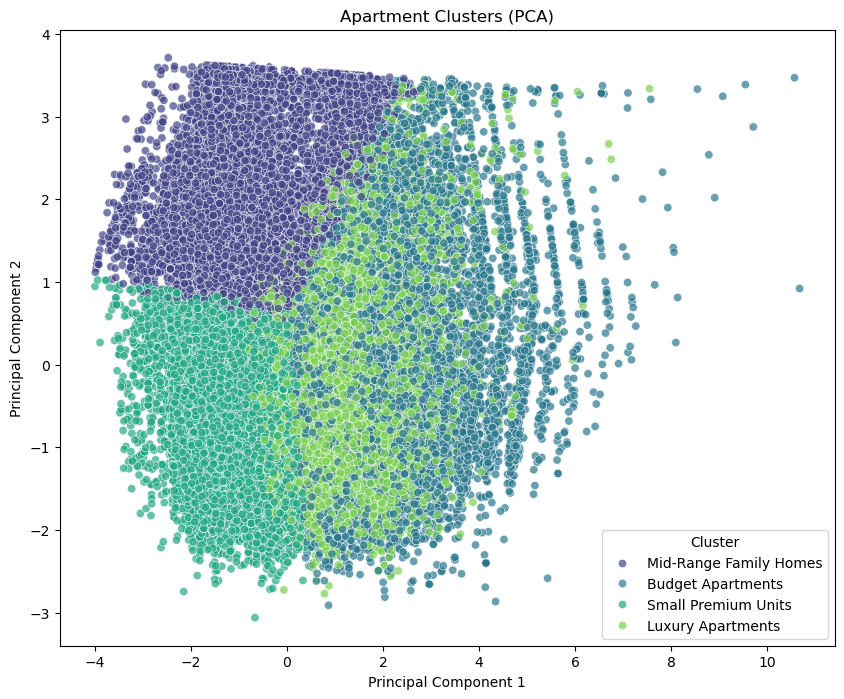

In [49]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], 
                hue=df['Cluster_Label'], palette='viridis', alpha=0.7)
plt.title('Apartment Clusters (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [51]:
# Save models
joblib.dump(kmeans, 'apartment_kmeans_model.pkl')
joblib.dump(scaler, 'apartment_scaler.pkl')
print("\nModels saved successfully!")



Models saved successfully!


In [ ]:
# Prediction function

In [53]:
def predict_apartment_cluster(new_apartment):
    new_df = pd.DataFrame([new_apartment])
    new_df['price_per_sqft'] = new_df['price'] / new_df['square_feet']
    new_df['has_pool'] = int('pool' in new_apartment.get('amenities', '').lower())
    new_df['has_gym'] = int('gym' in new_apartment.get('amenities', '').lower())
    new_df['has_parking'] = int('parking' in new_apartment.get('amenities', '').lower())
    
    features = new_df[['price', 'bedrooms', 'bathrooms', 'square_feet', 
                      'price_per_sqft', 'has_pool', 'has_gym', 'has_parking']]
    
    scaler = joblib.load('apartment_scaler.pkl')
    kmeans = joblib.load('apartment_kmeans_model.pkl')
    
    scaled_features = scaler.transform(features)
    cluster = kmeans.predict(scaled_features)[0]
    return cluster, cluster_labels[cluster]

In [55]:
# Test prediction
test_apartment = {
    'price': 2500,
    'bedrooms': 2,
    'bathrooms': 2,
    'square_feet': 1200,
    'amenities': 'Pool, Gym, Parking'
}
cluster_num, cluster_name = predict_apartment_cluster(test_apartment)
print(f"\nTest Apartment Prediction: Cluster {cluster_num} - {cluster_name}")


Test Apartment Prediction: Cluster 1 - Luxury Apartments
